# MolMIM Property Guided Molecular Optimization Using CMA-ES

<div class="alert alert-block alert-info"> <b>NOTE</b> This notebook was tested on a single RTX8000 GPU using BioNeMo Framework v1.7 with an expected runtime of approximately 1h.</div>

## Demo Objectives
Here we demonstrate how to load a [MolMIM](https://arxiv.org/abs/2208.09016) checkpoint from the BioNeMo Framework and use it to optimize some molecules of interest with a custom user-defined scoring function. We use [CMA-ES](https://en.wikipedia.org/wiki/CMA-ES) to traverse the latent space of our MolMIM model and select novel, related molecules expected to improve performance as measured by the scoring function. To sample these molecules, we must complete the following steps:

1. Load the desired MolMIM checkpoint.
2. Encode the starting molecules into MolMIM's latent space.
3. Run CMA-ES, which will iteratively perform the following:
    1. Decode latent representations into SMILES strings.
    2. Apply the user defined scoring function to these SMILES strings to generate SMILES/scores pairings.
    3. Ask the CMA-ES algorithm for a new set of latent space representations from which to sample.

Note: this notebook is derived from [a previous tutorial made for the BioNeMo Service version of MolMIM](https://github.com/NVIDIA/BioNeMo/blob/main/examples/service/notebooks/cma_custom_oracles.ipynb).



## Setup

Ensure that you have read through the Getting Started section, can run the BioNeMo Framework docker container, and have configured the NGC Command Line Interface (CLI) within the container. It is assumed that this notebook is being executed from within the container.

<div class="alert alert-block alert-info"> <b>NOTE</b> Some of the cells below generate long text output.  We're using <pre>%%capture --no-display --no-stderr cell_output</pre> to suppress this output.  Comment or delete this line in the cells below to restore full output.</div>

### Import and install all required packages

In [1]:
%%capture --no-display --no-stderr cell_output
!pip install optuna
!pip install statsmodels

from bionemo.utils.hydra import load_model_config
import os
from bionemo.model.molecule.molmim.infer import MolMIMInference
from typing import List, Optional
import numpy as np
from guided_molecule_gen.oracles import qed, tanimoto_similarity
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.QED import qed as rdkit_qed
from bionemo.model.core.controlled_generation import ControlledGenerationPerceiverEncoderInferenceWrapper
from guided_molecule_gen.optimizer import MoleculeGenerationOptimizer
import optuna
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import trange
import logging
logging.basicConfig(level = logging.INFO)
logging.getLogger("nemo_logger").setLevel(logging.ERROR)

### Home Directory

In [2]:
bionemo_home = "/workspace/bionemo"
os.environ['BIONEMO_HOME'] = bionemo_home
os.chdir(bionemo_home)

### Download Model Checkpoints
In the commands below, provide your own NGC API Key and NGC Org.

In [3]:
# Define the NGC CLI API KEY and ORG for the model download
# If these variables are not already set in the container, uncomment below
# to define and set with your API KEY and ORG
#api_key = <your_api_key>
#ngc_cli_org = <ngc_cli_org>
# Update the environment variable
#os.environ['NGC_CLI_API_KEY'] = api_key
#os.environ['NGC_CLI_ORG'] = ngc_cli_org

# Set variables and paths for model and checkpoint
model_name = "molmim_70m_24_3"
actual_checkpoint_name = "molmim_70m_24_3.nemo"
model_path = os.path.join(bionemo_home, 'models')
checkpoint_path = os.path.join(model_path, actual_checkpoint_name)
os.environ['MODEL_PATH'] = model_path


In [4]:
%%capture --no-display --no-stderr cell_output
if not os.path.exists(checkpoint_path):
    !cd /workspace/bionemo && \
    python download_artifacts.py --model_dir models --models {model_name}
else:
    print(f"Model {model_name} already exists at {model_path}.")

### Load your checkpoint into the molmim inference wrapper

In [5]:
%%capture --no-display --no-stderr cell_output
os.environ['BIONEMO_HOME'] = bionemo_home
cfg = load_model_config(config_name="molmim_infer.yaml", config_path=f"{bionemo_home}/examples/tests/conf/") # reasonable starting config for molmim inference
# This is the field of the config that we need to set to our desired checkpoint path.
cfg.model.downstream_task.restore_from_path = checkpoint_path
model = MolMIMInference(cfg, interactive=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
24-08-06 21:08:36 - PID:1051 - rank:(0, 0, 0, 0) - microbatches.py:39 - INFO - setting number of micro-batches to constant 1


### Setup user-defined molecule scoring function
This is the section where you as a user can pull in your own scoring functions that you want to optimize. For this example, we will be optimizing a combination of Tanimoto similarity to the input molecule and Quantitative Estimate of Druglikeness (QED) following the example from the initial [MolMIM publication](https://arxiv.org/abs/2208.09016):

$$
  score = min(QED / 0.9, 1) + min(Tanimoto / 0.4, 1)
$$

In this case, we will allow the model to optimize up to a maximum QED of 0.9 and Tanimoto similarity of 0.4. Once these maxima are achieved, we perform no further optimization. 

In [6]:
def score_mixing_function(qeds: np.ndarray, similarities: np.ndarray) -> np.ndarray:
    """
    Calculate a combined score for QED and Tanimoto similarity. This function aims to maximize the Quantitative Estimate of Drug-likeness (QED) and Tanimoto similarity scores up to thresholds of 0.9 and 0.4, respectively.
    """
    return np.clip(qeds / 0.9, a_min=0.0, a_max=1.0) + np.clip(similarities / 0.4, a_min=0.0, a_max=1.0)

def try_canon(smiles:str) -> Optional[str]:
    """
    Attempt to canonicalize a SMILES string. This function tries to convert a SMILES string to its canonical form. If the conversion fails, it returns None.
    """
    try:
        return Chem.MolToSmiles(Chem.MolFromSmiles(smiles), canonical=True)
    except:
        return None

def canonicalize(smiles: List[str]) -> List[str]:
    """
    Canonicalize a list of SMILES strings. This function converts each SMILES string in the input list to its canonical form.
    """
    return [try_canon(s) for s in smiles]

def scoring_function(smiles: List[str], reference:str, **kwargs) -> np.ndarray:
    """Takes a list of SMILES strings and returns an array of scores.

    Args:
        smiles (List[str]): Smiles strings to generate a score for (one each)
        reference (str): Reference molecule (SMILES string) is also used for this scoring function.

    Returns:
        np.ndarray: Array of scores, one for each input SMILES string.
    """
    #csmiles = canonicalize(smiles)
    scores: np.ndarray = score_mixing_function(qed(smiles), tanimoto_similarity(smiles, reference))
    return -1 * scores

### Define starting molecules
In this section, we will define the starting molecules for the optimization process. As a set of examples, we will use imatinib, erlotinib, and gifitinib. We ensure that the SMILES strings representing these molecules are canonicalized using RDKit. MolMIM was trained on a corpus of RDKit-cononicalized SMILES strings, so any inputs and outputs should be RDKit-canonicalized as well to achieve peak performance.

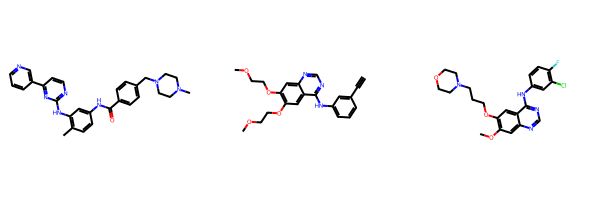

In [7]:
starting_smiles = [
    "CC1=C(C=C(C=C1)NC(=O)C2=CC=C(C=C2)CN3CCN(CC3)C)NC4=NC=CC(=N4)C5=CN=CC=C5", # imatinib
    "COCCOC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC=CC(=C3)C#C)OCCOC", # erlotinib
    "C1COCCN1CCCOc2c(OC)cc3ncnc(c3c2)Nc4cc(Cl)c(F)cc4", # gifitinib
]

# Canonicalize all SMILES strings and print the structure of imatinib
molecules = [Chem.MolFromSmiles(s) for s in starting_smiles]
starting_qed = [rdkit_qed(m) for m in molecules]
canonicalized_smiles = [Chem.MolToSmiles(m, canonical=True) for m in molecules]
Draw.MolsToGridImage(molecules)

### Setup the optimizer and wrap the inference API for CMA-ES
The CMA-ES library expects certain formats for input/output of the inference model to function properly. We provide a wrapper for this and show how to setup optimization below.

In [8]:
controlled_gen_kwargs = {
    "sampling_method": "beam-search",
    "sampling_kwarg_overrides": {"beam_size": 3, "keep_only_best_tokens": True, "return_scores": False},
}

model_wrapped = ControlledGenerationPerceiverEncoderInferenceWrapper(
    model, enforce_perceiver=True, hidden_steps=1, **controlled_gen_kwargs
)  # just flatten the position for this.

### Tune CMA-ES
Different models will have different optimal settings for CMA-ES. Here, we perform a grid search over possible values of `sigma`, then perform more steps of optimization with the best. We will use the [Optuna library](https://optuna.org/) to perform this optimization over the `sigma` hyperparameter. This process is referred to as hyperparatemer optimization or HPO.

<div class="alert alert-block alert-info"> <b>NOTE</b>
This grid search may take some time depending on system and GPU capabilities.  We are running a relatively small search with <pre>    n_trials=10</pre> in the call <pre>    study.optimize(objective, n_trials=10)</pre>

If time and compute resources allow, increasing the number of trials should improve results.
</div>

In [9]:
%%capture --no-display --no-stderr cell_output
%%time
def objective(trial, n_steps:int=10) -> float:
    """
    Objective function for hyperparameter optimization using Optuna. This function optimizes the `sigma` parameter for the `MoleculeGenerationOptimizer` to maximize the final score of generated molecules.
    """
    sigma = trial.suggest_float('sigma', 0, 2)
    optimizer = MoleculeGenerationOptimizer(
        model_wrapped,
        scoring_function,
        canonicalized_smiles,
        popsize=10,  # larger values will be slower but more thorough
        optimizer_args={"sigma": sigma},
    )
    optimizer.optimize(n_steps)
    final_smiles = optimizer.generated_smis
    final_score = np.mean([np.min(scoring_function(smis_population, reference_smis)) for smis_population,reference_smis in zip(final_smiles, canonicalized_smiles)])
    return final_score

study = optuna.create_study()
study.optimize(objective, n_trials=10);

[I 2024-08-06 21:08:41,741] A new study created in memory with name: no-name-e2642617-c6bc-4c5a-813e-a6cae2d4baa4
[I 2024-08-06 21:09:11,937] Trial 0 finished with value: -1.7908240508539937 and parameters: {'sigma': 1.1436448372973909}. Best is trial 0 with value: -1.7908240508539937.
[I 2024-08-06 21:09:41,187] Trial 1 finished with value: -1.7217557525583158 and parameters: {'sigma': 1.136744045254513}. Best is trial 0 with value: -1.7908240508539937.
[I 2024-08-06 21:10:10,489] Trial 2 finished with value: -1.8005730720088875 and parameters: {'sigma': 1.0661960913392319}. Best is trial 2 with value: -1.8005730720088875.
[I 2024-08-06 21:10:39,759] Trial 3 finished with value: -1.77196442822935 and parameters: {'sigma': 0.8399371318462481}. Best is trial 2 with value: -1.8005730720088875.
[I 2024-08-06 21:11:08,869] Trial 4 finished with value: -1.3730382455389722 and parameters: {'sigma': 1.8505535722293203}. Best is trial 2 with value: -1.8005730720088875.
[I 2024-08-06 21:11:38,2

Now, we can examine the best performing value for `sigma` found by Optuna during HPO.

In [10]:
study.best_params

{'sigma': 0.44103950412533544}

Though the above value is the optimium returned over our HPO process, we will consider the range of valid values and pick a minimum that is more likely to be robust. Since the HPO process is stochastic, high-performing and low-performing values may be in close proximity. We would like to identify a good range of `sigma` values, over which the optimizer generally performs well.

In [11]:
completed_trials = [trial for trial in study.trials if trial.state == optuna.trial.TrialState.COMPLETE]
trials_data = [{"sigma": trial.params["sigma"], "loss": trial.value, "trial_id": tid} for tid,trial in enumerate(completed_trials)]
data = pd.DataFrame(trials_data)
data
# Now create a bootstrap confidence interval around the a LOWESS fit


def lowess_with_confidence_bounds(x, y, eval_x, N=200, conf_interval=0.95, lowess_kw=None) -> tuple:
    """
    Perform Lowess regression and determine a confidence interval by bootstrap resampling
    """
    # Lowess smoothing
    #  x is called (exog), y is called (endog)
    smoothed = sm.nonparametric.lowess(exog=x, endog=y, xvals=eval_x, **lowess_kw)

    # Perform bootstrap resamplings of the data
    # and  evaluate the smoothing at a fixed set of points
    smoothed_values = np.empty((N, len(eval_x)))
    for i in range(N):
        sample = np.random.choice(len(x), len(x), replace=True)
        sampled_x = x[sample]
        sampled_y = y[sample]

        smoothed_values[i] = sm.nonparametric.lowess(
            exog=sampled_x, endog=sampled_y, xvals=eval_x, **lowess_kw
        )

    # Get the confidence interval
    sorted_values = np.sort(smoothed_values, axis=0)
    bound = int(N * (1 - conf_interval) / 2)
    bottom = sorted_values[bound - 1]
    top = sorted_values[-bound]

    return smoothed, bottom, top


# Compute the 95% confidence interval
eval_x = np.linspace(0, 2, 200)
smoothed, bottom, top = lowess_with_confidence_bounds(
    data.sigma, data.loss, eval_x, lowess_kw={"frac": .8}
)

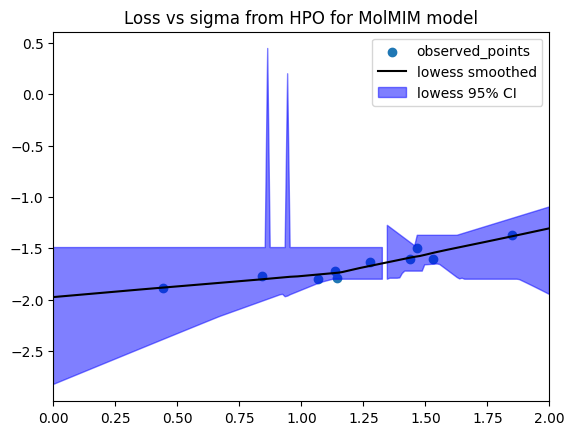

In [12]:
plt.scatter(x=data["sigma"], y=data["loss"], label="observed_points")
plt.plot(eval_x, smoothed, c="k", label="lowess smoothed")
plt.fill_between(eval_x, bottom, top, alpha=0.5, color="b", label="lowess 95% CI")
plt.legend()
plt.title("Loss vs sigma from HPO for MolMIM model")
plt.autoscale(enable=True, axis="x", tight=True);

In [13]:
smoothed_best_sigma = eval_x[np.argmin(top)]  # Use the upper bound of the confidence interval
smooth_best = {"sigma": smoothed_best_sigma}
smooth_best

{'sigma': 1.3366834170854272}

We now compare the smoothed top choice with the best nominal choice.

In [14]:
smooth_best, study.best_params

({'sigma': 1.3366834170854272}, {'sigma': 0.44103950412533544})

### Run a larger CMA-ES optimization with discovered parameters
Given the value of `sigma` we found to work well in our HPO above, we will increase the population size and steps and do a final larger optimizaiton run.

In [15]:
%%capture --no-display --no-stderr cell_output
%%time
optimizer = MoleculeGenerationOptimizer(
        model_wrapped,
        scoring_function,
        canonicalized_smiles,
        popsize=50,  # larger values will be slower but more thorough
        optimizer_args=smooth_best,  # Vals from HPO
    )
# Starting state for idx 0
qed_scores = [qed(canonicalized_smiles)]
tanimoto_scores = [[tanimoto_similarity([canonicalized_smiles[idx]], canonicalized_smiles[idx])[0] for idx in range(len(canonicalized_smiles))]]
best_molecules = [canonicalized_smiles]
fraction_bad_samples = [[0]*len(canonicalized_smiles)]
for i in trange(30):
    optimizer.step();
    final_smiles = optimizer.generated_smis
    # Population of molecules is returned, but we only want the best one.
    _qed_scores = []
    _tanimoto_scores = []
    _best_molecules = []
    _fraction_bad = []
    for smis_population,reference_smis in zip(final_smiles, canonicalized_smiles):
        idx = np.argmin(scoring_function(smis_population, reference_smis))
        _fraction_bad.append(np.mean(qed(smis_population) == 0))
        _best_molecules.append(smis_population[idx])
        _qed_scores.append(qed([smis_population[idx]])[0])
        _tanimoto_scores.append(tanimoto_similarity([smis_population[idx]], reference_smis)[0])
    qed_scores.append(_qed_scores)
    tanimoto_scores.append(_tanimoto_scores)
    best_molecules.append(_best_molecules)
    fraction_bad_samples.append(_fraction_bad)

100%|███████████████████████████████████████████████████████████████| 30/30 [04:18<00:00,  8.62s/it]


### Explore results
Below, we create a plot disaplaying how the components of our target (QED and Tanimoto similarity) changed over each iteration. By our target definition, any value above 0.4 for Tanimoto similarity would be optimal so we expect noise around that value. Similarly, for QED any value above 0.9 would be optimal so we expect noise around that value if any molecule surpasses that threshold.

Text(0.5, 1.0, 'Targets over time for MolMIM model')

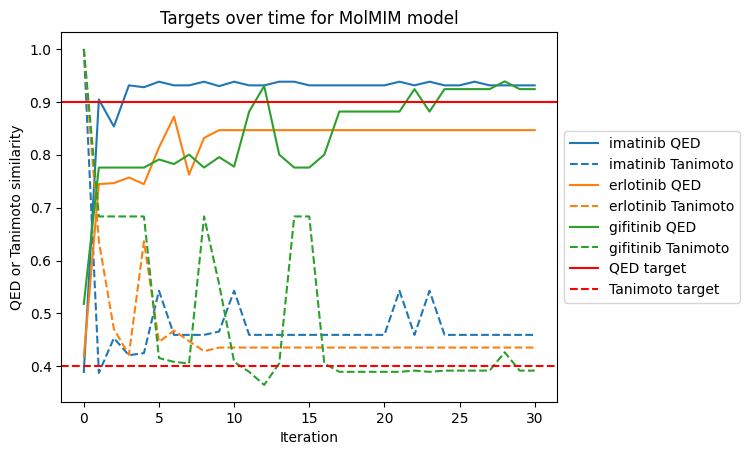

In [16]:
for i, molecule in enumerate(["imatinib", "erlotinib", "gifitinib"]):
    line, = plt.plot(np.arange(len(qed_scores)), [q[i] for q in qed_scores], label=f"{molecule} QED")
    color = line.get_color()
    plt.plot(np.arange(len(tanimoto_scores)), [t[i] for t in tanimoto_scores], label=f"{molecule} Tanimoto", linestyle="--", color=color)
plt.axhline(y=0.9, color='r', linestyle='-', label="QED target")
plt.axhline(y=0.4, color='r', linestyle='--', label="Tanimoto target")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("Iteration")
plt.ylabel("QED or Tanimoto similarity")
plt.title("Targets over time for MolMIM model")

### How well did our optimization perform?
To examine the performance of out optimization, we can quantify the number of invalid samples that were generated. An "invalid" SMILES is defined as a SMILES string that does not represent a chemically-valid underlying molecule.

In [17]:
np.mean(fraction_bad_samples)

0.0040860215053763445

We can finally quantify the improvement in QED over the baseline value and the fraction of our optimized molecules that maintained the desired Tanimoto similarity threshold above 0.4.

In [18]:
qed_improvements = []
tanimoto_above_04 = []
for i in range(len(starting_qed)):
    tanimoto_above_04.append(tanimoto_scores[-1][i] >= 0.4)
    qed_improvements.append(qed_scores[-1][i] - starting_qed[i])
{"mean_qed_improvement": np.mean(qed_improvements), "tanimoto_above_04": np.mean(tanimoto_above_04)}

{'mean_qed_improvement': 0.45881201826825063,
 'tanimoto_above_04': 0.6666666666666666}